In [1]:
import os, copy, math, random, time
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import pandas as pd

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cuda


In [ ]:
from dataclasses import dataclass
from typing import Tuple

@dataclass
class CFG:
    dataset: str = "fashionmnist"
    num_classes: int = 10

    num_clients: int = 10
    client_fraction: float = 1.0
    rounds: int = 15
    local_epochs: int = 5
    batch_size: int = 256
    test_batch_size: int = 512

    lr: float = 0.01
    momentum: float = 0.9
    weight_decay: float = 5e-4

    prox_mu: float = 0.001

    sam_rho: float = 0.05
    sam_rho_min: float = 0.01
    sam_rho_max: float = 0.2

    adaptive_rho_mode: str = "grad_norm"

    lw_mode: str = "upweight_hard"
    lw_gamma: float = 1.0
    lw_eps: float = 1e-8

    qfed_q: float = 1.0

    server_momentum: float = 0.9

    alphas: Tuple[float, ...] = (0.1, 0.5)

    use_fedbn: bool = False

cfg = CFG()
print(cfg)


CFG(dataset='fashionmnist', num_classes=10, num_clients=10, client_fraction=1.0, rounds=15, local_epochs=5, batch_size=256, test_batch_size=512, lr=0.01, momentum=0.9, weight_decay=0.0005, prox_mu=0.001, sam_rho=0.05, sam_rho_min=0.01, sam_rho_max=0.2, adaptive_rho_mode='grad_norm', lw_mode='upweight_hard', lw_gamma=1.0, lw_eps=1e-08, qfed_q=1.0, server_momentum=0.9, alphas=(0.1, 0.5), use_fedbn=False)


In [ ]:
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

def get_fashion_mnist():
    mean = (0.2860,)
    std  = (0.3530,)

    transform_train = T.Compose([
        T.RandomCrop(28, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean, std),
    ])
    transform_test = T.Compose([
        T.ToTensor(),
        T.Normalize(mean, std),
    ])

    trainset = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform_train)
    testset  = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform_test)
    return trainset, testset

trainset, testset = get_fashion_mnist()
print("train:", len(trainset), "test:", len(testset))

test_loader = DataLoader(
    testset,
    batch_size=cfg.test_batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 191kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.53MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.5MB/s]

train: 60000 test: 10000


In [4]:
import numpy as np
import pandas as pd
from torch.utils.data import Subset, DataLoader

def _targets_to_numpy(dataset):
    t = dataset.targets
    if isinstance(t, torch.Tensor):
        return t.cpu().numpy()
    return np.array(t)

def dirichlet_partition(dataset, num_clients: int, alpha: float, num_classes: int, seed: int = 42):
    rng = np.random.default_rng(seed)
    targets = _targets_to_numpy(dataset)

    class_indices = [np.where(targets == c)[0] for c in range(num_classes)]
    for c in range(num_classes):
        rng.shuffle(class_indices[c])

    client_indices = [[] for _ in range(num_clients)]

    for c in range(num_classes):
        proportions = rng.dirichlet([alpha] * num_clients)
        proportions = proportions / proportions.sum()

        idx_c = class_indices[c]
        splits = (np.cumsum(proportions) * len(idx_c)).astype(int)[:-1]
        parts = np.split(idx_c, splits)

        for k in range(num_clients):
            client_indices[k].extend(parts[k].tolist())

    for k in range(num_clients):
        rng.shuffle(client_indices[k])

    return client_indices

def make_client_loaders(dataset, client_indices, batch_size: int, shuffle=True):
    loaders = []
    for idxs in client_indices:
        subset = Subset(dataset, idxs)
        loader = DataLoader(
            subset,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=2,
            pin_memory=True,
            drop_last=False
        )
        loaders.append(loader)
    return loaders

def summarize_split(dataset, client_indices, num_classes: int):
    targets = _targets_to_numpy(dataset)
    rows = []
    for k, idxs in enumerate(client_indices):
        y = targets[idxs]
        counts = [(y == c).sum() for c in range(num_classes)]
        rows.append([k, len(idxs)] + counts)
    cols = ["client", "n"] + [f"class_{c}" for c in range(num_classes)]
    return pd.DataFrame(rows, columns=cols)


In [ ]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10, in_channels=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool  = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1   = nn.Linear(128 * 7 * 7, 256)
        self.fc2   = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def build_model():
    return SmallCNN(num_classes=cfg.num_classes, in_channels=1)

loss_fn = nn.CrossEntropyLoss()


In [ ]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = loss_fn(logits, y)
        total_loss += loss.item() * y.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return total_loss / total, correct / total

def is_bn_key(k: str) -> bool:
    k_low = k.lower()
    if "running_mean" in k_low or "running_var" in k_low or "num_batches_tracked" in k_low:
        return True
    return ".bn" in k_low or k_low.startswith("bn") or ".bn" in k_low or "bn" in k_low

def aggregate_state_dicts(
    global_state: Dict[str, torch.Tensor],
    client_states: List[Dict[str, torch.Tensor]],
    weights: List[float],
    use_fedbn: bool
):
    new_state = {}
    wsum = sum(weights) + 1e-12
    for k in global_state.keys():
        if use_fedbn and is_bn_key(k):
            new_state[k] = global_state[k].clone()
            continue

        acc = None
        for sd, w in zip(client_states, weights):
            t = sd[k].to(global_state[k].device)
            if acc is None:
                acc = (w / wsum) * t
            else:
                acc += (w / wsum) * t
        new_state[k] = acc
    return new_state

def sample_clients(num_clients, fraction, rng):
    m = max(1, int(round(num_clients * fraction)))
    return rng.choice(num_clients, size=m, replace=False).tolist()


In [ ]:
def grad_norm(model: nn.Module) -> torch.Tensor:
    norms = []
    for p in model.parameters():
        if p.grad is None:
            continue
        norms.append(torch.norm(p.grad.detach(), p=2))
    if len(norms) == 0:
        return torch.tensor(0.0, device=device)
    return torch.norm(torch.stack(norms), p=2)

@torch.no_grad()
def add_scaled_grad_(model: nn.Module, scale: float):
    for p in model.parameters():
        if p.grad is None:
            continue
        p.add_(p.grad, alpha=scale)

@torch.no_grad()
def save_params(model: nn.Module):
    return [p.detach().clone() for p in model.parameters()]

@torch.no_grad()
def load_params(model: nn.Module, params_backup):
    for p, b in zip(model.parameters(), params_backup):
        p.copy_(b)

def sam_batch_update(model, optimizer, x, y, rho: float):
    model.train()
    optimizer.zero_grad(set_to_none=True)
    logits = model(x)
    loss = loss_fn(logits, y)
    loss.backward()

    gnorm = grad_norm(model)
    scale = rho / (gnorm + 1e-12)

    backup = save_params(model)
    add_scaled_grad_(model, scale)

    optimizer.zero_grad(set_to_none=True)
    logits2 = model(x)
    loss2 = loss_fn(logits2, y)
    loss2.backward()

    load_params(model, backup)
    optimizer.step()

    return loss.item(), loss2.item(), gnorm.item()


In [ ]:
def make_optimizer(model):
    return torch.optim.SGD(model.parameters(), lr=cfg.lr, momentum=cfg.momentum, weight_decay=cfg.weight_decay)

def local_train_sgd(model, loader, epochs=1):
    model.train()
    opt = make_optimizer(model)
    total_loss, total_n = 0.0, 0
    for _ in range(epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            opt.step()
            total_loss += loss.item() * y.size(0)
            total_n += y.size(0)
    return total_loss / max(1, total_n)

def local_train_fedprox(model, global_model, loader, epochs=1, mu=0.001):
    model.train()
    opt = make_optimizer(model)
    g_params = [p.detach().clone() for p in global_model.parameters()]
    total_loss, total_n = 0.0, 0

    for _ in range(epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(x)
            loss = loss_fn(logits, y)

            prox = 0.0
            for p, gp in zip(model.parameters(), g_params):
                prox = prox + (p - gp).pow(2).sum()
            loss = loss + (mu / 2.0) * prox

            loss.backward()
            opt.step()

            total_loss += loss.item() * y.size(0)
            total_n += y.size(0)

    return total_loss / max(1, total_n)

def local_train_fedsam(model, loader, epochs=1, rho=0.05):
    opt = make_optimizer(model)
    total_loss, total_n = 0.0, 0
    for _ in range(epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            l1, l2, _ = sam_batch_update(model, opt, x, y, rho=rho)
            total_loss += l2 * y.size(0)
            total_n += y.size(0)
    return total_loss / max(1, total_n)

def compute_adaptive_rho(client_stat: float, ref_stat: float, rho0: float, rho_min: float, rho_max: float):
    ratio = client_stat / (ref_stat + 1e-12)
    rho = rho0 * ratio
    return float(np.clip(rho, rho_min, rho_max))

@torch.no_grad()
def get_one_batch(loader):
    for x, y in loader:
        return x.to(device), y.to(device)
    raise RuntimeError("empty loader")

def client_probe_stats(model, loader):
    model.train()
    x, y = get_one_batch(loader)
    for p in model.parameters():
        if p.grad is not None:
            p.grad = None
    logits = model(x)
    loss = loss_fn(logits, y)
    loss.backward()
    gn = grad_norm(model).item()
    return loss.item(), gn

def local_train_adaptive_sam(model, loader, epochs, rho_for_client: float):
    opt = make_optimizer(model)
    total_loss, total_n = 0.0, 0
    for _ in range(epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            _, l2, _ = sam_batch_update(model, opt, x, y, rho=rho_for_client)
            total_loss += l2 * y.size(0)
            total_n += y.size(0)
    return total_loss / max(1, total_n)

@torch.no_grad()
def apply_global_perturbation(model, direction_state, rho):
    for name, p in model.named_parameters():
        if name in direction_state:
            d = direction_state[name].to(p.device)
            p.add_(d, alpha=rho)

@torch.no_grad()
def remove_global_perturbation(model, direction_state, rho):
    for name, p in model.named_parameters():
        if name in direction_state:
            d = direction_state[name].to(p.device)
            p.add_(d, alpha=-rho)

def normalize_direction_state(direction_state):
    sq = 0.0
    for v in direction_state.values():
        sq += (v.detach().float().norm(p=2) ** 2).item()
    norm = math.sqrt(sq) + 1e-12
    out = {k: (v / norm) for k, v in direction_state.items()}
    return out, norm

def local_train_lesam(model, loader, epochs, global_direction_state, rho):
    opt = make_optimizer(model)
    total_loss, total_n = 0.0, 0

    for _ in range(epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            apply_global_perturbation(model, global_direction_state, rho)

            opt.zero_grad(set_to_none=True)
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()

            remove_global_perturbation(model, global_direction_state, rho)
            opt.step()

            total_loss += loss.item() * y.size(0)
            total_n += y.size(0)

    return total_loss / max(1, total_n)


In [ ]:
def weights_fedavg(client_sizes):
    return [float(n) for n in client_sizes]

def weights_uniform(num_clients):
    return [1.0] * num_clients

def weights_fedlw(client_sizes, client_losses, mode="upweight_hard", gamma=1.0, eps=1e-8):
    ws = []
    for n, l in zip(client_sizes, client_losses):
        if mode == "upweight_hard":
            ws.append(float(n) * float((l + eps) ** gamma))
        else:
            ws.append(float(n) / float((l + eps) ** gamma))
    return ws

def weights_qfedavg(client_sizes, client_losses, q=1.0, eps=1e-8):
    return [float(n) * float((l + eps) ** q) for n, l in zip(client_sizes, client_losses)]


In [ ]:
def state_dict_to_cpu(sd):
    return {k: v.detach().cpu().clone() for k, v in sd.items()}

def run_one_alpha(alpha: float, seed: int = 42):
    rng = np.random.default_rng(seed)

    client_indices = dirichlet_partition(trainset, cfg.num_clients, alpha=alpha, num_classes=cfg.num_classes, seed=seed)
    client_loaders = make_client_loaders(trainset, client_indices, batch_size=cfg.batch_size, shuffle=True)

    client_sizes = [len(idxs) for idxs in client_indices]

    WA_ALGOS = [
        "FedAvg",
        "Uniform",
        "FedProx",
        "qFedAvg",
        "FedAvgM",
        "FedLW",
        "FedSCAM_WA",
    ]

    SAM_ALGOS = [
        "FedSAM",
        "FedLESAM",
        "FedWMSAM",
        "FedLWSAM",
        "FedSCAM_SAM",
    ]

    FULL_ALGOS = ["FedSCAM_FULL"]

    ALL_ALGOS = WA_ALGOS + SAM_ALGOS + FULL_ALGOS

    results = {algo: {"acc": [], "loss": []} for algo in ALL_ALGOS}

    for algo in ALL_ALGOS:
        global_model = build_model().to(device)
        global_state = copy.deepcopy(global_model.state_dict())

        server_m = None
        if algo in ["FedAvgM", "FedWMSAM"] or "AvgM" in algo:
            server_m = {k: torch.zeros_like(v) for k, v in global_state.items()}

        print(f"\n=== alpha={alpha} | algo={algo} ===")
        for r in range(1, cfg.rounds + 1):
            selected = sample_clients(cfg.num_clients, cfg.client_fraction, rng)

            probe_losses, probe_gns, probe_grads = [], [], []

            if algo in ["FedSCAM_SAM", "FedSCAM_FULL", "FedLESAM"]:
                for k in selected:
                    m = build_model().to(device)
                    m.load_state_dict(global_state)
                    l, gn = client_probe_stats(m, client_loaders[k])
                    probe_losses.append(l)
                    probe_gns.append(gn)

                    if algo == "FedLESAM":
                        gstate = {}
                        for name, p in m.named_parameters():
                            if p.grad is None:
                                continue
                            gstate[name] = p.grad.detach().clone()
                        probe_grads.append(gstate)

                ref_loss = float(np.mean(probe_losses)) if len(probe_losses) else 1.0
                ref_gn   = float(np.mean(probe_gns)) if len(probe_gns) else 1.0

                if algo == "FedLESAM":
                    avg_g = {}
                    for gstate in probe_grads:
                        for name, g in gstate.items():
                            if name not in avg_g:
                                avg_g[name] = g.detach().clone()
                            else:
                                avg_g[name] += g.detach().clone()
                    for name in avg_g:
                        avg_g[name] /= max(1, len(probe_grads))
                    avg_g, _ = normalize_direction_state(avg_g)
                else:
                    avg_g = None
            else:
                ref_loss, ref_gn, avg_g = None, None, None

            client_states = []
            client_train_losses = []
            selected_sizes = []

            for k in selected:
                local_model = build_model().to(device)
                local_model.load_state_dict(global_state)

                if algo in ["FedAvg", "Uniform", "FedLW", "FedSCAM_WA", "qFedAvg", "FedAvgM"]:
                    tr_loss = local_train_sgd(local_model, client_loaders[k], epochs=cfg.local_epochs)

                elif algo == "FedProx":
                    gmodel = build_model().to(device)
                    gmodel.load_state_dict(global_state)
                    tr_loss = local_train_fedprox(local_model, gmodel, client_loaders[k],
                                                  epochs=cfg.local_epochs, mu=cfg.prox_mu)

                elif algo in ["FedSAM", "FedWMSAM", "FedLWSAM"]:
                    tr_loss = local_train_fedsam(local_model, client_loaders[k],
                                                 epochs=cfg.local_epochs, rho=cfg.sam_rho)

                elif algo in ["FedSCAM_SAM", "FedSCAM_FULL"]:
                    idx = selected.index(k)
                    if cfg.adaptive_rho_mode == "loss":
                        stat = probe_losses[idx]
                        ref  = ref_loss
                    else:
                        stat = probe_gns[idx]
                        ref  = ref_gn

                    rho_k = compute_adaptive_rho(stat, ref, cfg.sam_rho, cfg.sam_rho_min, cfg.sam_rho_max)
                    tr_loss = local_train_adaptive_sam(local_model, client_loaders[k],
                                                       epochs=cfg.local_epochs, rho_for_client=rho_k)

                elif algo == "FedLESAM":
                    tr_loss = local_train_lesam(local_model, client_loaders[k],
                                                epochs=cfg.local_epochs,
                                                global_direction_state=avg_g,
                                                rho=cfg.sam_rho)
                else:
                    raise ValueError(f"Unknown algo: {algo}")

                client_states.append(copy.deepcopy(local_model.state_dict()))
                client_train_losses.append(float(tr_loss))
                selected_sizes.append(client_sizes[k])

            if algo == "FedAvg":
                agg_w = weights_fedavg(selected_sizes)
            elif algo == "Uniform":
                agg_w = weights_uniform(len(selected))
            elif algo == "FedProx":
                agg_w = weights_fedavg(selected_sizes)
            elif algo == "qFedAvg":
                agg_w = weights_qfedavg(selected_sizes, client_train_losses, q=cfg.qfed_q, eps=cfg.lw_eps)
            elif algo == "FedAvgM":
                agg_w = weights_fedavg(selected_sizes)
            elif algo == "FedLW":
                agg_w = weights_fedlw(selected_sizes, client_train_losses, mode=cfg.lw_mode,
                                      gamma=cfg.lw_gamma, eps=cfg.lw_eps)
            elif algo == "FedSCAM_WA":
                agg_w = weights_fedlw(selected_sizes, client_train_losses, mode=cfg.lw_mode,
                                      gamma=cfg.lw_gamma, eps=cfg.lw_eps)
            elif algo == "FedSAM":
                agg_w = weights_fedavg(selected_sizes)
            elif algo == "FedLESAM":
                agg_w = weights_fedavg(selected_sizes)
            elif algo == "FedWMSAM":
                agg_w = weights_fedavg(selected_sizes)
            elif algo == "FedLWSAM":
                agg_w = weights_fedlw(selected_sizes, client_train_losses, mode=cfg.lw_mode,
                                      gamma=cfg.lw_gamma, eps=cfg.lw_eps)
            elif algo == "FedSCAM_SAM":
                agg_w = weights_fedavg(selected_sizes)
            elif algo == "FedSCAM_FULL":
                agg_w = weights_fedlw(selected_sizes, client_train_losses, mode=cfg.lw_mode,
                                      gamma=cfg.lw_gamma, eps=cfg.lw_eps)
            else:
                agg_w = weights_fedavg(selected_sizes)

            if algo in ["FedAvgM", "FedWMSAM"]:
                new_avg_state = aggregate_state_dicts(global_state, client_states, agg_w, use_fedbn=cfg.use_fedbn)
                delta = {k: (new_avg_state[k] - global_state[k]) for k in global_state.keys()}

                beta = cfg.server_momentum
                for k in server_m:
                    server_m[k] = beta * server_m[k] + (1.0 - beta) * delta[k]

                global_state = {k: (global_state[k] + server_m[k]) for k in global_state.keys()}
            else:
                global_state = aggregate_state_dicts(global_state, client_states, agg_w, use_fedbn=cfg.use_fedbn)

            global_model.load_state_dict(global_state)
            te_loss, te_acc = evaluate(global_model, test_loader)
            results[algo]["acc"].append(te_acc)
            results[algo]["loss"].append(te_loss)

            print(f"Round {r:02d}/{cfg.rounds} | test_acc={te_acc*100:.2f}% | test_loss={te_loss:.4f}")

    return results

def plot_group(results_alpha, alpha, algos, title):
    plt.figure(figsize=(10, 5))
    for a in algos:
        plt.plot(np.arange(1, cfg.rounds+1), results_alpha[a]["acc"], label=a)
    plt.xlabel("Round")
    plt.ylabel("Test Accuracy")
    plt.title(f"{title} | alpha={alpha}")
    plt.grid(True)
    plt.legend()
    plt.show()

def final_table(all_results):
    rows = []
    for alpha, res in all_results.items():
        for algo, vals in res.items():
            rows.append({
                "alpha": alpha,
                "algo": algo,
                "final_acc": vals["acc"][-1],
                "best_acc": max(vals["acc"]),
            })
    df = pd.DataFrame(rows).sort_values(["alpha", "final_acc"], ascending=[True, False])
    return df

all_results = {}
for a in cfg.alphas:
    all_results[a] = run_one_alpha(alpha=a, seed=42)

df = final_table(all_results)
display(df)



=== alpha=0.1 | algo=FedAvg ===
Round 01/15 | test_acc=54.22% | test_loss=1.3664
Round 02/15 | test_acc=64.51% | test_loss=0.8568
Round 03/15 | test_acc=64.06% | test_loss=1.0888
Round 04/15 | test_acc=59.00% | test_loss=0.9631
Round 05/15 | test_acc=64.13% | test_loss=1.1860
Round 06/15 | test_acc=74.37% | test_loss=0.7449
Round 07/15 | test_acc=68.89% | test_loss=0.7500
Round 08/15 | test_acc=77.19% | test_loss=0.6009
Round 09/15 | test_acc=72.62% | test_loss=0.6554
Round 10/15 | test_acc=76.00% | test_loss=0.5929
Round 11/15 | test_acc=75.68% | test_loss=0.5817
Round 12/15 | test_acc=77.22% | test_loss=0.5529
Round 13/15 | test_acc=79.69% | test_loss=0.4858
Round 14/15 | test_acc=77.10% | test_loss=0.5642
Round 15/15 | test_acc=80.89% | test_loss=0.4700

=== alpha=0.1 | algo=Uniform ===
Round 01/15 | test_acc=29.66% | test_loss=1.8043
Round 02/15 | test_acc=67.02% | test_loss=0.9521
Round 03/15 | test_acc=56.10% | test_loss=1.0629
Round 04/15 | test_acc=61.73% | test_loss=0.9505
Ro

,alpha,algo,final_acc,best_acc
7,0.1,FedSAM,0.8436,0.8436
11,0.1,FedSCAM_SAM,0.8253,0.8253
10,0.1,FedLWSAM,0.8142,0.8142
5,0.1,FedLW,0.8139,0.8332
0,0.1,FedAvg,0.8089,0.8089
6,0.1,FedSCAM_WA,0.7934,0.7967
4,0.1,FedAvgM,0.7830,0.7830
9,0.1,FedWMSAM,0.7683,0.7683
2,0.1,FedProx,0.7659,0.7978
3,0.1,qFedAvg,0.7572,0.8005


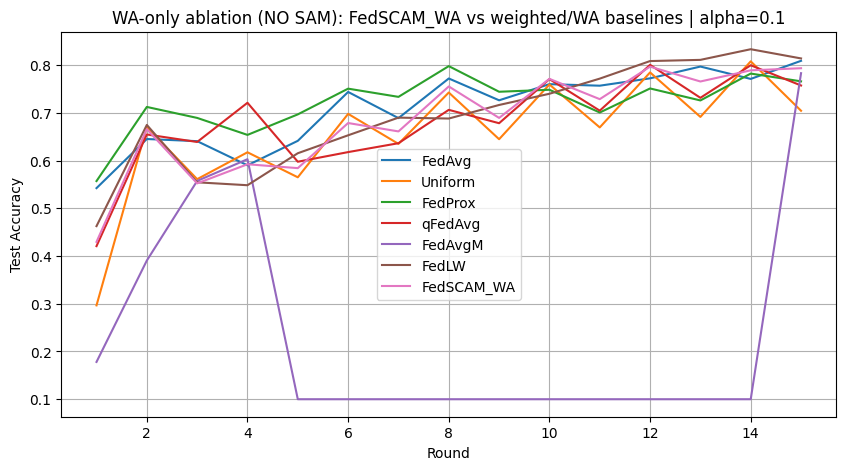

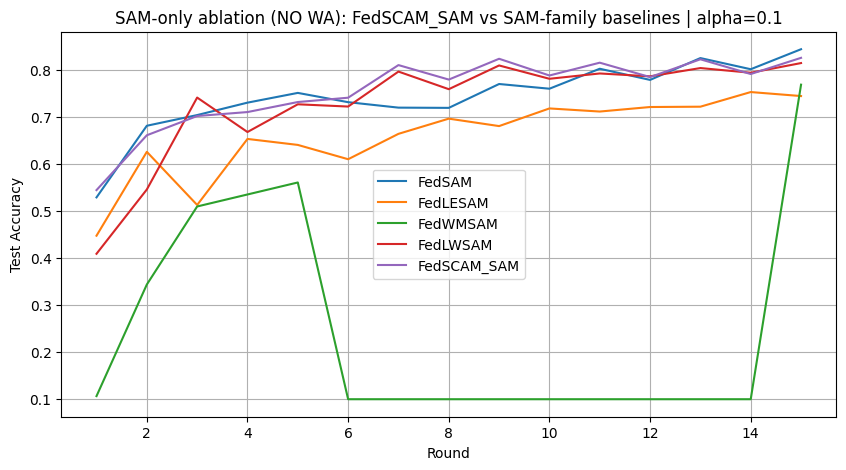

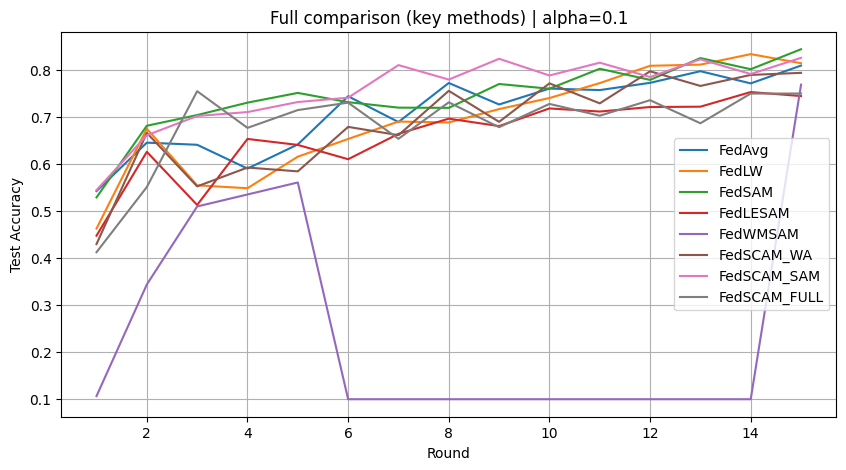

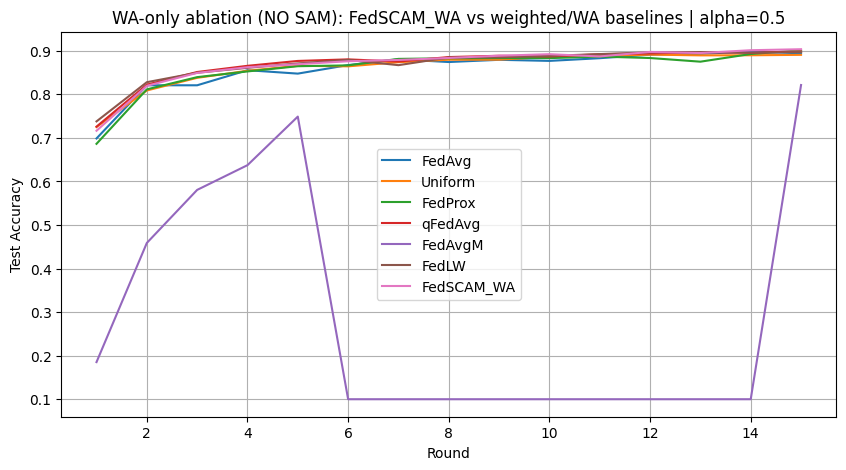

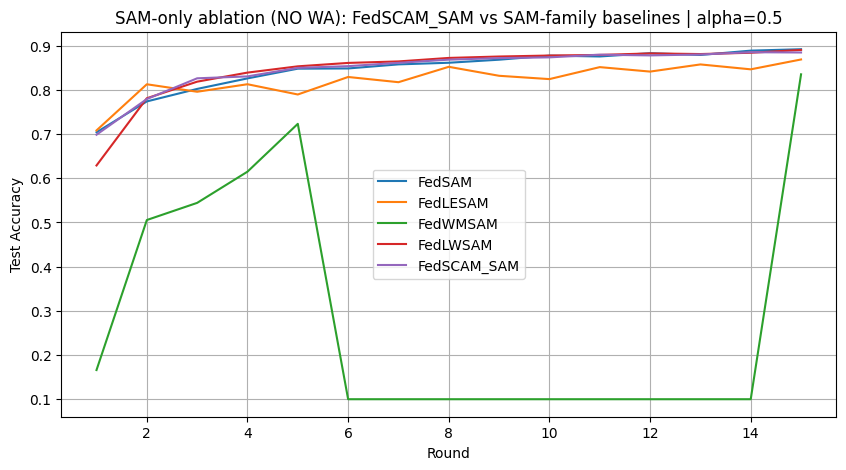

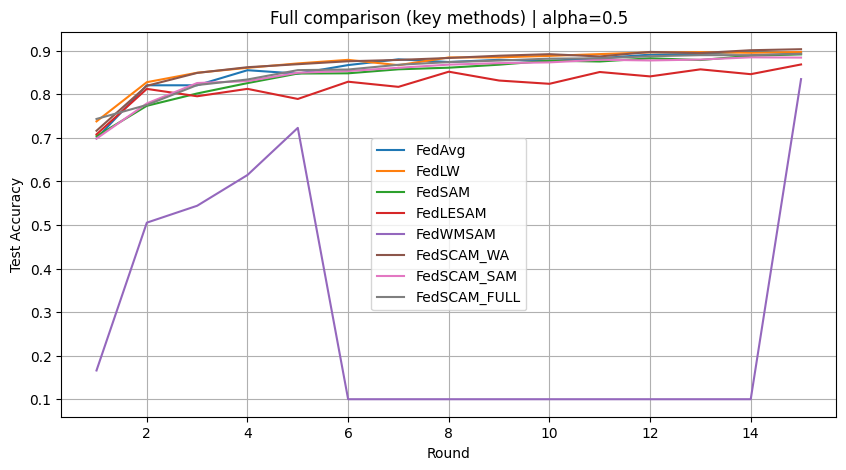

In [ ]:
WA_ALGOS = ["FedAvg","Uniform","FedProx","qFedAvg","FedAvgM","FedLW","FedSCAM_WA"]
SAM_ALGOS = ["FedSAM","FedLESAM","FedWMSAM","FedLWSAM","FedSCAM_SAM"]
FULL = ["FedSCAM_FULL"]

for alpha in cfg.alphas:
    res = all_results[alpha]

    plot_group(res, alpha, WA_ALGOS, "WA-only ablation (NO SAM): FedSCAM_WA vs weighted/WA baselines")
    plot_group(res, alpha, SAM_ALGOS, "SAM-only ablation (NO WA): FedSCAM_SAM vs SAM-family baselines")

    key = ["FedAvg","FedLW","FedSAM","FedLESAM","FedWMSAM","FedSCAM_WA","FedSCAM_SAM","FedSCAM_FULL"]
    plot_group(res, alpha, key, "Full comparison (key methods)")


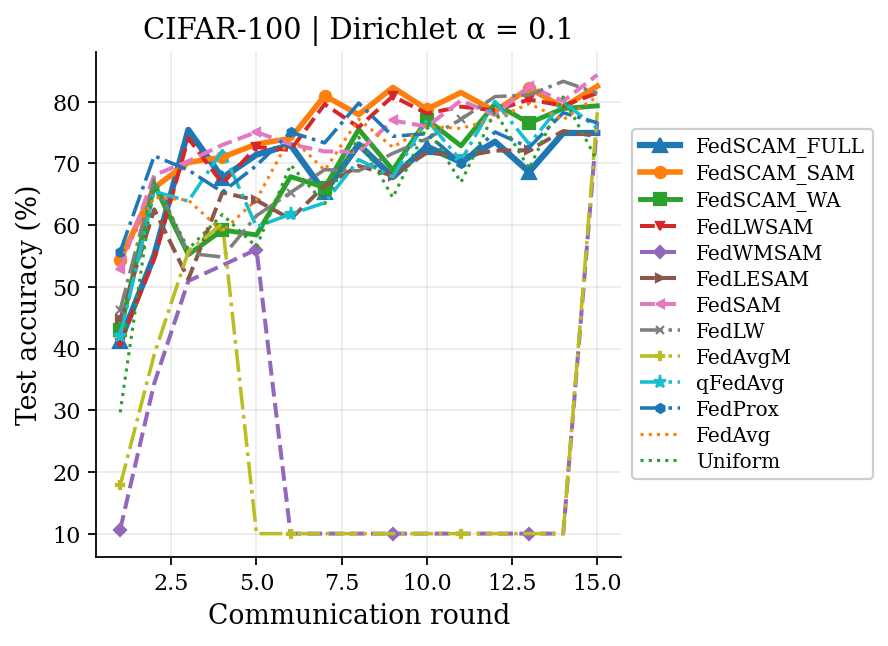

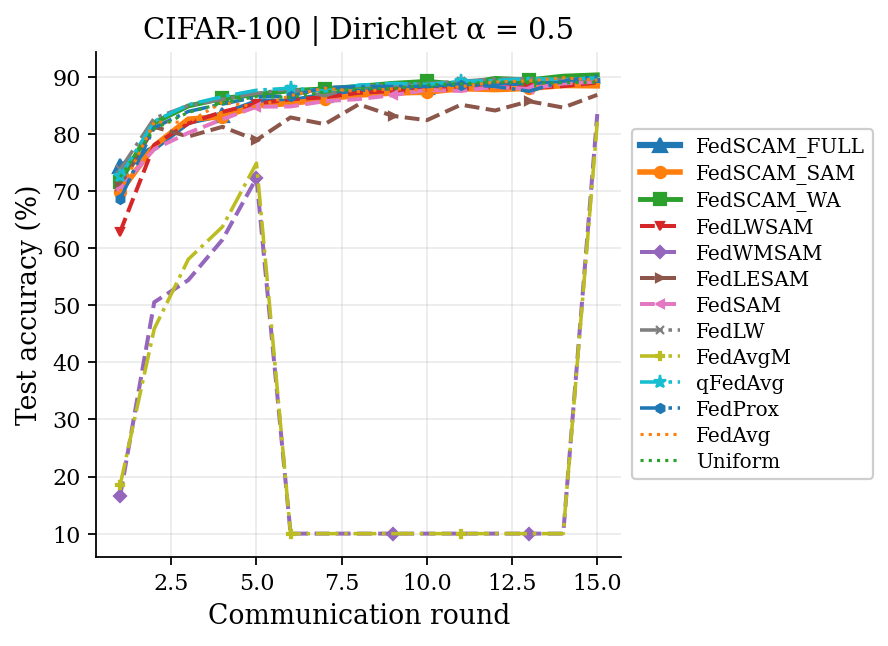

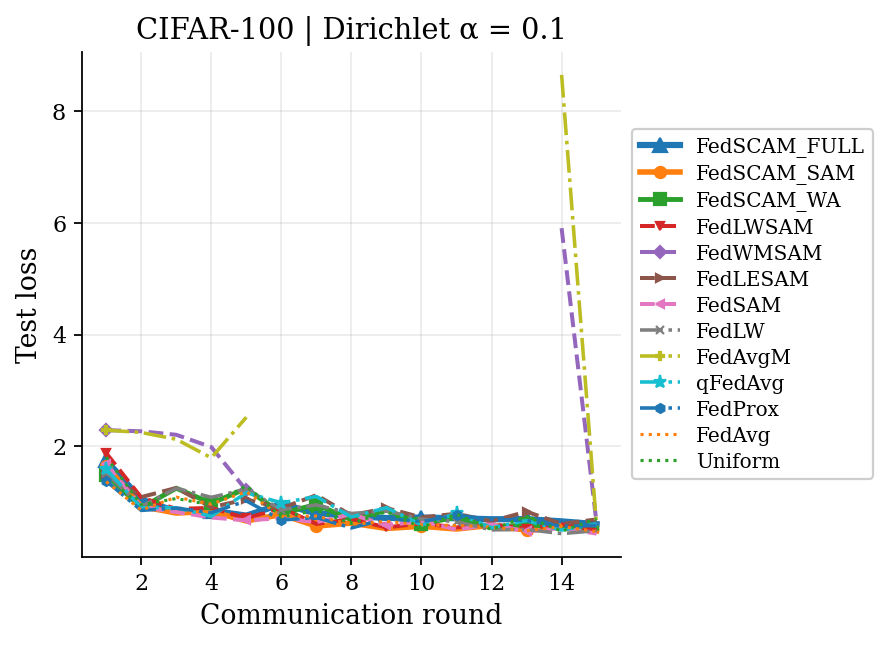

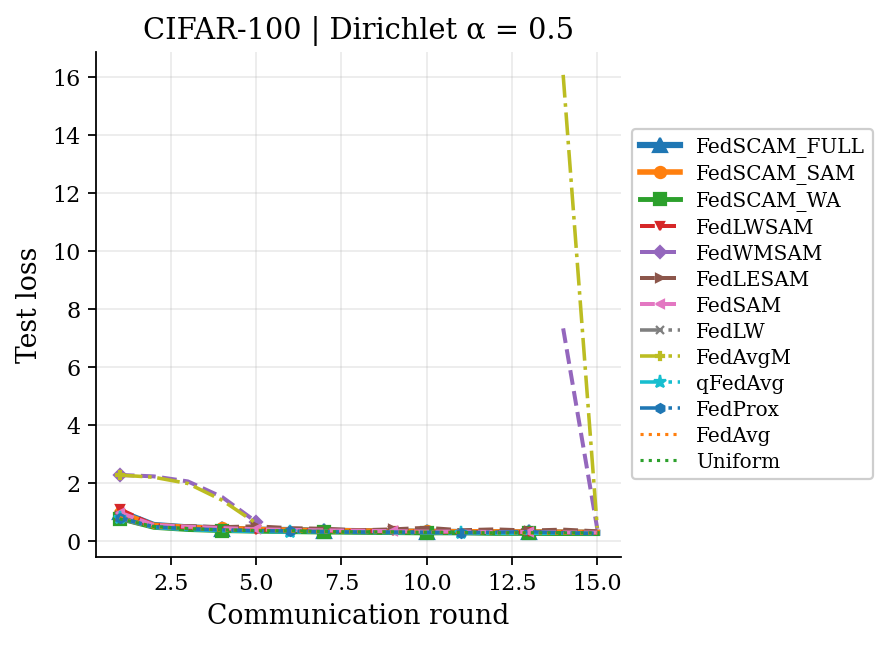

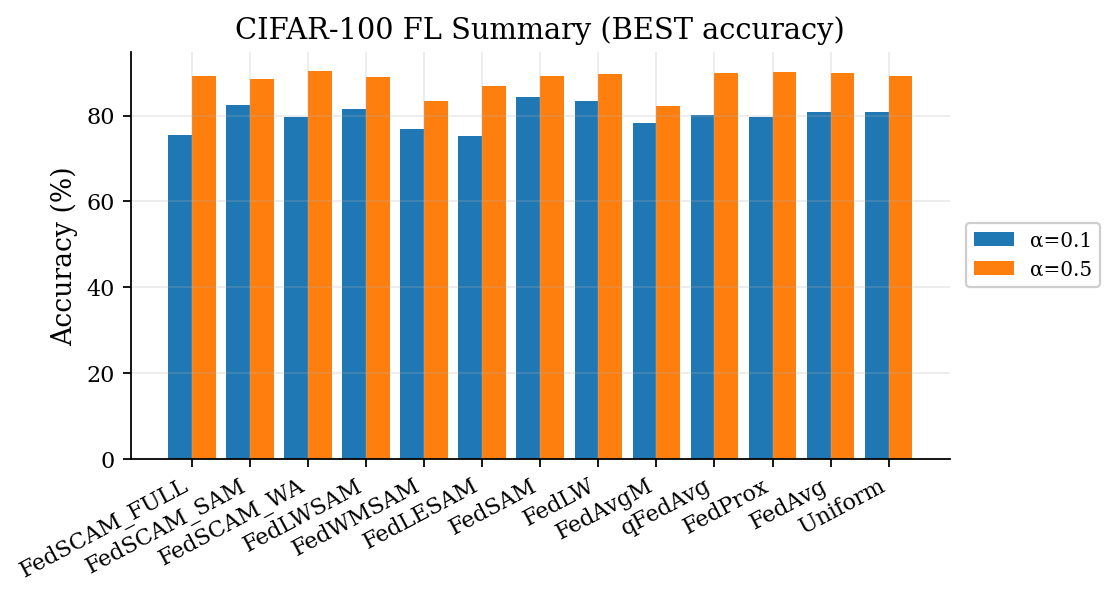

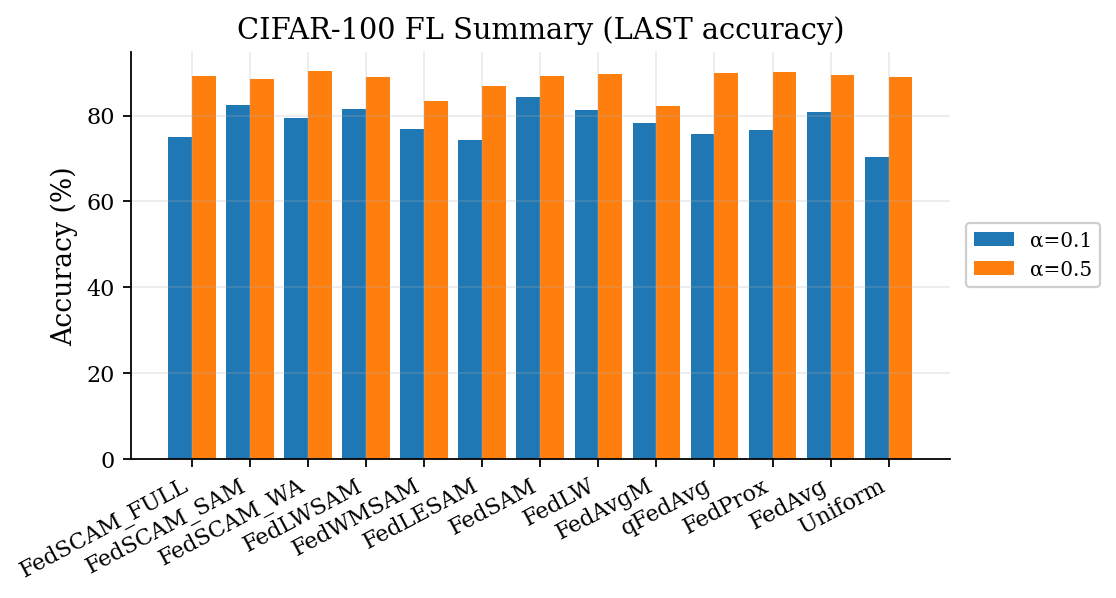

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "legend.fontsize": 9, 
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 160,
})

def _algo_present(res_alpha, algo):
    return (algo in res_alpha) and ("acc" in res_alpha[algo]) and (len(res_alpha[algo]["acc"]) > 0)

def _get_rounds(res_alpha, algo):
    return np.arange(1, len(res_alpha[algo]["acc"]) + 1)

STYLE = {
    "FedSCAM_FULL": dict(linestyle="-",  marker="^", linewidth=2.8, markersize=6, markevery=3),
    "FedSCAM_SAM":  dict(linestyle="-",  marker="o", linewidth=2.5, markersize=5, markevery=3),
    "FedSCAM_WA":   dict(linestyle="-",  marker="s", linewidth=2.2, markersize=5, markevery=3),

    "FedLWSAM":     dict(linestyle="--", marker="v", linewidth=1.8, markersize=4, markevery=4),
    "FedWMSAM":     dict(linestyle="--", marker="D", linewidth=1.8, markersize=4, markevery=4),
    "FedLESAM":     dict(linestyle="--", marker=">", linewidth=1.8, markersize=4, markevery=4),
    "FedSAM":       dict(linestyle="--", marker="<", linewidth=1.8, markersize=4, markevery=4),

    "FedLW":        dict(linestyle="-.", marker="x", linewidth=1.6, markersize=4, markevery=5),
    "FedAvgM":      dict(linestyle="-.", marker="P", linewidth=1.6, markersize=4, markevery=5),
    "qFedAvg":      dict(linestyle="-.", marker="*", linewidth=1.6, markersize=6, markevery=5),
    "FedProx":      dict(linestyle="-.", marker="h", linewidth=1.6, markersize=4, markevery=5),

    "FedAvg":       dict(linestyle=":",  marker=None, linewidth=1.4),
    "Uniform":      dict(linestyle=":",  marker=None, linewidth=1.4),
}

def _apply_icml_axes_style(ax):
    ax.grid(True, alpha=0.25)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

def plot_curves_per_alpha(
    all_results,
    alphas=None,
    algos=None,
    metric="acc",
    title_prefix="CIFAR-100",
    ylim=None,
    figsize=(7.2, 4.2),
    legend_cols=1,
    save_prefix=None
):
    if alphas is None:
        alphas = sorted(list(all_results.keys()))
    if algos is None:
        algos = list(next(iter(all_results.values())).keys())

    for alpha in alphas:
        res_alpha = all_results[alpha]
        present_algos = [a for a in algos if _algo_present(res_alpha, a)]
        if len(present_algos) == 0:
            print(f"[WARN] No algos present for alpha={alpha}")
            continue

        fig, ax = plt.subplots(figsize=figsize)

        for algo in present_algos:
            xs = _get_rounds(res_alpha, algo)
            ys = np.array(res_alpha[algo][metric], dtype=float)
            if metric == "acc":
                ys = ys * 100.0

            kw = STYLE.get(algo, {})
            ax.plot(xs, ys, label=algo, **kw)

        ax.set_xlabel("Communication round")
        ax.set_ylabel("Test accuracy (%)" if metric == "acc" else "Test loss")
        ax.set_title(f"{title_prefix} | Dirichlet α = {alpha}")

        if ylim is not None:
            ax.set_ylim(*ylim)

        _apply_icml_axes_style(ax)

        leg = ax.legend(
            ncol=legend_cols,
            loc="center left",
            bbox_to_anchor=(1.02, 0.5),
            frameon=True,
            framealpha=0.95,
            borderaxespad=0.0,
            handlelength=2.0,
            labelspacing=0.35
        )

        fig.tight_layout(rect=[0.0, 0.0, 0.80, 1.0])

        if save_prefix is not None:
            fig.savefig(f"{save_prefix}_alpha{alpha}_{metric}.pdf", bbox_inches="tight")
            fig.savefig(f"{save_prefix}_alpha{alpha}_{metric}.png", bbox_inches="tight")

        plt.show()
        plt.close(fig)

def plot_summary_bar(
    all_results,
    alphas=None,
    algos=None,
    mode="best",
    title="FL Summary",
    figsize=(8.2, 3.9),
    save_path=None
):
    if alphas is None:
        alphas = sorted(list(all_results.keys()))
    if algos is None:
        s = set()
        for a in alphas:
            s |= set(all_results[a].keys())
        algos = sorted(list(s))

    keep = []
    for algo in algos:
        if any(alpha in all_results and _algo_present(all_results[alpha], algo) for alpha in alphas):
            keep.append(algo)
    algos = keep
    if len(algos) == 0:
        print("[WARN] No algorithms found to summarize.")
        return

    vals = np.zeros((len(algos), len(alphas)), dtype=float)
    for j, alpha in enumerate(alphas):
        res_alpha = all_results[alpha]
        for i, algo in enumerate(algos):
            if not _algo_present(res_alpha, algo):
                vals[i, j] = np.nan
                continue
            accs = np.array(res_alpha[algo]["acc"], dtype=float) * 100.0
            vals[i, j] = np.nanmax(accs) if mode == "best" else accs[-1]

    x = np.arange(len(algos))
    width = 0.82 / len(alphas)

    fig, ax = plt.subplots(figsize=figsize)

    for j, alpha in enumerate(alphas):
        ax.bar(x + j * width, vals[:, j], width=width, label=f"α={alpha}")

    ax.set_xticks(x + (len(alphas)-1)*width/2)
    ax.set_xticklabels(algos, rotation=28, ha="right")
    ax.set_ylabel("Accuracy (%)")
    ax.set_title(f"{title} ({mode.upper()} accuracy)")

    _apply_icml_axes_style(ax)

    ax.legend(
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=True,
        framealpha=0.95,
        borderaxespad=0.0
    )

    fig.tight_layout(rect=[0.0, 0.0, 0.82, 1.0])

    if save_path is not None:
        fig.savefig(save_path, bbox_inches="tight")

    plt.show()
    plt.close(fig)

preferred_order = [
    "FedSCAM_FULL", "FedSCAM_SAM", "FedSCAM_WA",
    "FedLWSAM", "FedWMSAM", "FedLESAM", "FedSAM",
    "FedLW", "FedAvgM", "qFedAvg", "FedProx",
    "FedAvg", "Uniform",
]

alphas_to_plot = sorted(list(all_results.keys()))

plot_curves_per_alpha(
    all_results,
    alphas=alphas_to_plot,
    algos=preferred_order,
    metric="acc",
    title_prefix="CIFAR-100",
    ylim=None,
    figsize=(7.2, 4.2),
    legend_cols=1,
    save_prefix=None
)

plot_curves_per_alpha(
    all_results,
    alphas=alphas_to_plot,
    algos=preferred_order,
    metric="loss",
    title_prefix="CIFAR-100",
    ylim=None,
    figsize=(7.2, 4.2),
    legend_cols=1,
    save_prefix=None
)

plot_summary_bar(
    all_results,
    alphas=alphas_to_plot,
    algos=preferred_order,
    mode="best",
    title="CIFAR-100 FL Summary",
    figsize=(8.6, 3.9),
    save_path=None
)

plot_summary_bar(
    all_results,
    alphas=alphas_to_plot,
    algos=preferred_order,
    mode="last",
    title="CIFAR-100 FL Summary",
    figsize=(8.6, 3.9),
    save_path=None
)


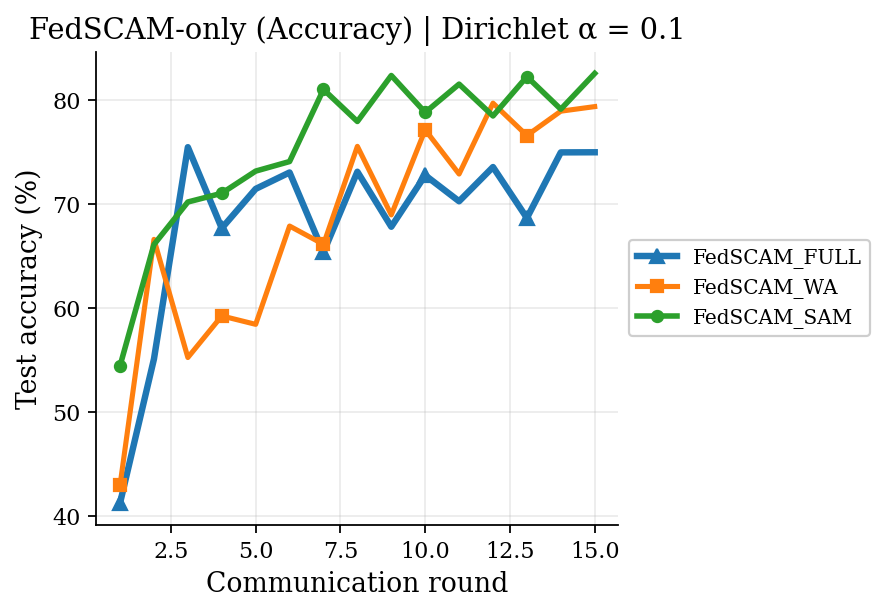

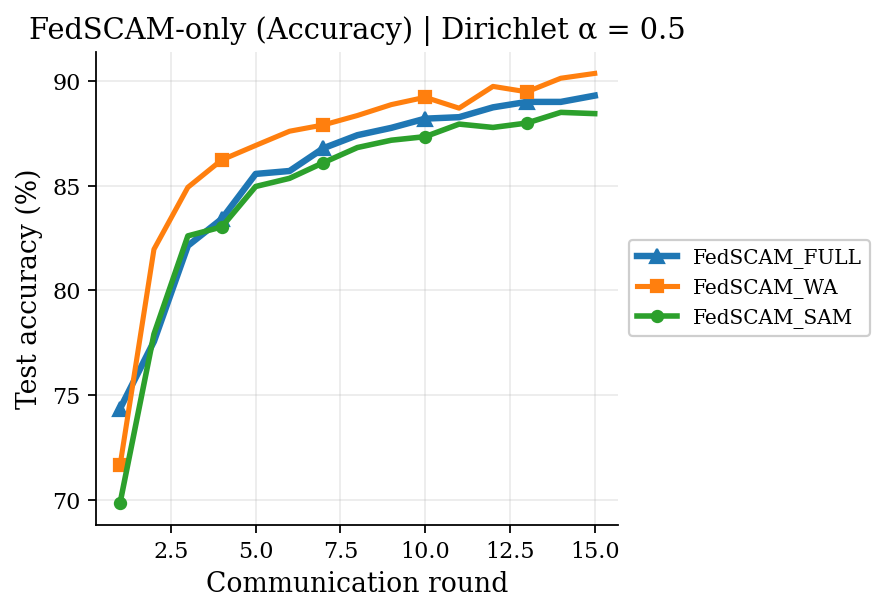

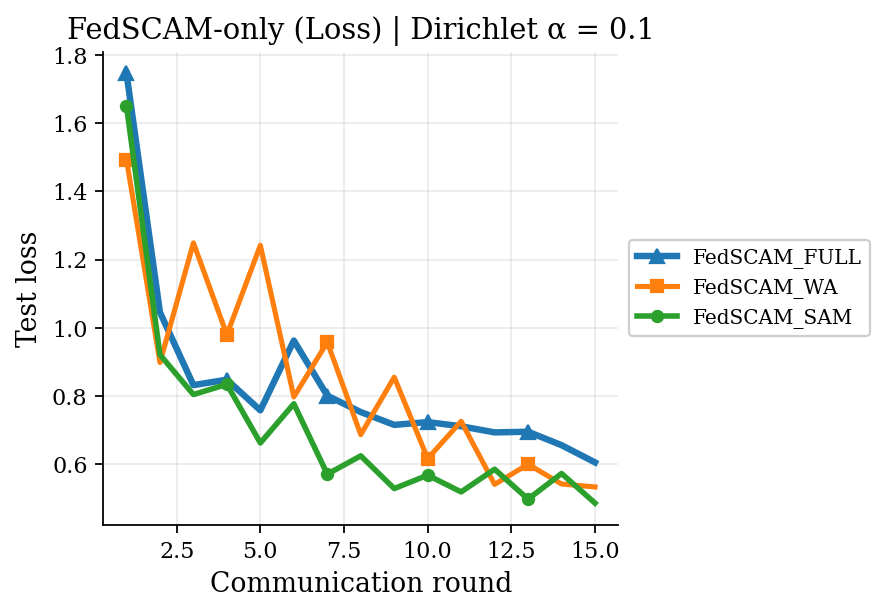

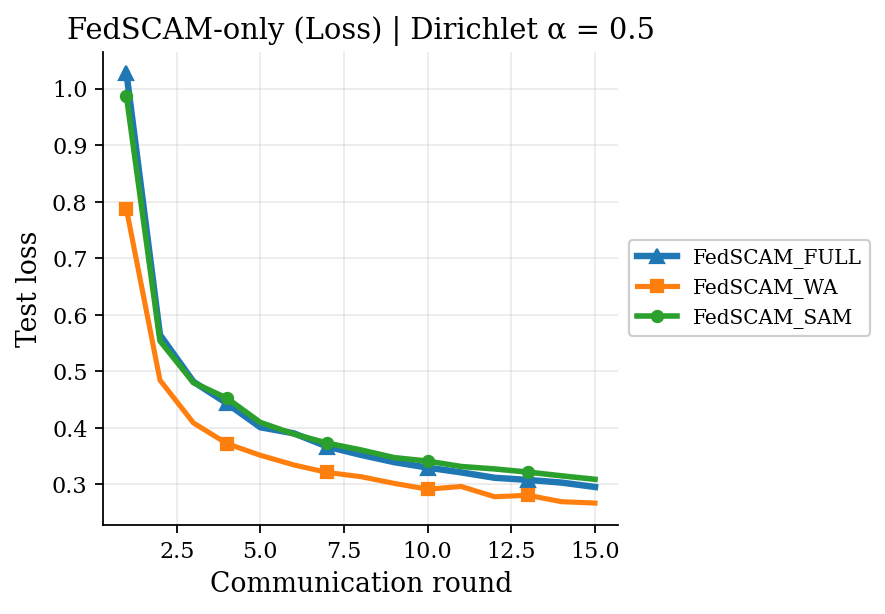

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "legend.fontsize": 9,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 160,
})

SCAM_ONLY = ["FedSCAM_FULL", "FedSCAM_WA", "FedSCAM_SAM"]

SCAM_STYLE = {
    "FedSCAM_FULL": dict(linestyle="-", marker="^", linewidth=2.9, markersize=6, markevery=3),
    "FedSCAM_WA":   dict(linestyle="-", marker="s", linewidth=2.3, markersize=5, markevery=3),
    "FedSCAM_SAM":  dict(linestyle="-", marker="o", linewidth=2.5, markersize=5, markevery=3),
}

def _apply_icml_axes_style(ax):
    ax.grid(True, alpha=0.25)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

def plot_fedscam_only(all_results, metric="acc", title_prefix="FedSCAM Ablation", ylim=None,
                      figsize=(7.0, 4.0), save_prefix=None):
    alphas = sorted(list(all_results.keys()))
    for alpha in alphas:
        res_alpha = all_results[alpha]

        present = []
        for a in SCAM_ONLY:
            if (a in res_alpha) and (metric in res_alpha[a]) and (len(res_alpha[a][metric]) > 0):
                present.append(a)

        if len(present) == 0:
            print(f"[WARN] No FedSCAM curves found for alpha={alpha}")
            continue

        fig, ax = plt.subplots(figsize=figsize)
        for algo in present:
            ys = np.array(res_alpha[algo][metric], dtype=float)
            if metric == "acc":
                ys = ys * 100.0
            xs = np.arange(1, len(ys) + 1)
            ax.plot(xs, ys, label=algo, **SCAM_STYLE.get(algo, {}))

        ax.set_xlabel("Communication round")
        ax.set_ylabel("Test accuracy (%)" if metric == "acc" else "Test loss")
        ax.set_title(f"{title_prefix} | Dirichlet α = {alpha}")
        if ylim is not None:
            ax.set_ylim(*ylim)

        _apply_icml_axes_style(ax)

        ax.legend(
            loc="center left",
            bbox_to_anchor=(1.02, 0.5),
            frameon=True,
            framealpha=0.95,
            borderaxespad=0.0
        )

        fig.tight_layout(rect=[0.0, 0.0, 0.82, 1.0])

        if save_prefix is not None:
            fig.savefig(f"{save_prefix}_alpha{alpha}_{metric}.pdf", bbox_inches="tight")
            fig.savefig(f"{save_prefix}_alpha{alpha}_{metric}.png", bbox_inches="tight")

        plt.show()
        plt.close(fig)

plot_fedscam_only(all_results, metric="acc", title_prefix="FedSCAM-only (Accuracy)")
plot_fedscam_only(all_results, metric="loss", title_prefix="FedSCAM-only (Loss)")


In [13]:
# Toggle 1: FedBN off/on (can matter a lot in non-iid)
# cfg.use_fedbn = False

# Toggle 2: loss-weighting direction:
# cfg.lw_mode = "downweight_hard"  # vs "upweight_hard"

# Toggle 3: adaptive rho mode:
# cfg.adaptive_rho_mode = "loss"  # vs "grad_norm"

# Toggle 4: fixed rho to compare against adaptive rho:
# cfg.sam_rho = 0.05
# cfg.sam_rho_min = 0.05
# cfg.sam_rho_max = 0.05
